## Baseline classification results for catinous

In [1]:
from pytorch_lightning import Trainer
from catinous.CatsinomModel import CatsinomModel
from catinous.CatsinomDataset import CatsinomDataset
from catinous.CatsinomModelGramCache import CatsinomModelGramCache
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, auc, roc_curve
import pandas as pd
import seaborn as sns
from catinous.CatsinomDataset import Catsinom_Dataset_CatineousStream as StreamedDS
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%load_ext autoreload
%autoreload 2

In [2]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
    return target, output

def plot_test_roc(dsname, datasets, device, base_only=False):
    hparams = dict()
    hparams['root_dir'] = '/project/catinous/cat_data/'
    hparams['datasetfile'] = 'catsinom_' + dsname + '_dataset.csv'
    
    if base_only:
        dsname = dsname + 'base'
    
    model = CatsinomModel(argparse.Namespace(**hparams))
    model.load_state_dict(torch.load('/project/catinous/trained_models/' + dsname + '_iterations.pt'))
    model.to(device)
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(dsname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

In [87]:
def test_model_gram(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc_gram(dsname, datasets, device, base_only=False):
    hparams = dict()
    hparams['root_dir'] = '/project/catinous/cat_data/'
    hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
    hparams['batch_size'] = 2
    hparams['training_batch_size'] = 8
    hparams['transition_phase_after'] = 0.7
    hparams['cachemaximum'] = 8
    
    if base_only:
        dsname = dsname + 'base'
    
    model = CatsinomModelGramCache(argparse.Namespace(**hparams))
    model.load_state_dict(torch.load('/project/catinous/trained_models/' + dsname + '.pt'))
    model.to(device)
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model_gram(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(dsname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

# Loading test sets

In [80]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_lr_dataset.csv', split='test'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_hr_dataset.csv', split='test'), batch_size=8, num_workers=4)
device = torch.device('cuda')

## Testing LR model

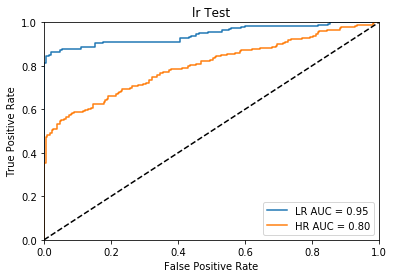

In [10]:
plot_test_roc('lr', {'LR': test_lr, 'HR': test_hr}, device)

## Testing LR-base model

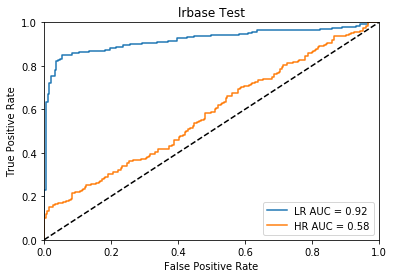

In [11]:
plot_test_roc('lr', {'LR': test_lr, 'HR': test_hr}, device, base_only=True)

## Testing HR Model

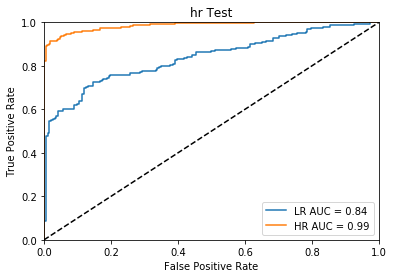

In [12]:
plot_test_roc('hr', {'LR': test_lr, 'HR': test_hr}, device)

## Testing HR-base model

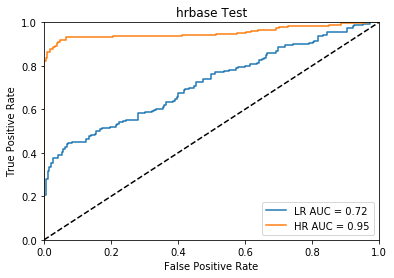

In [14]:
plot_test_roc('hr', {'LR': test_lr, 'HR': test_hr}, device, base_only=True)

## Testing combined model

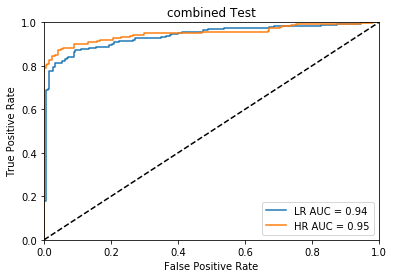

In [13]:
plot_test_roc('combined', {'LR': test_lr, 'HR': test_hr}, device)

## Testing LR-HR

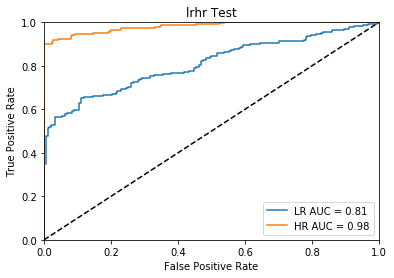

In [4]:
plot_test_roc('lrhr', {'LR': test_lr, 'HR': test_hr}, device)

## Testing HR-LR

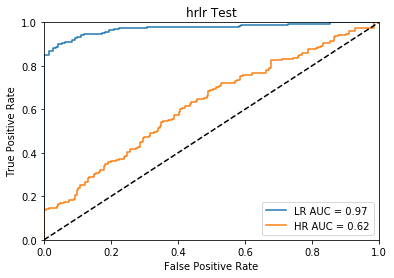

In [5]:
plot_test_roc('hrlr', {'LR': test_lr, 'HR': test_hr}, device)

# Continous training random cache

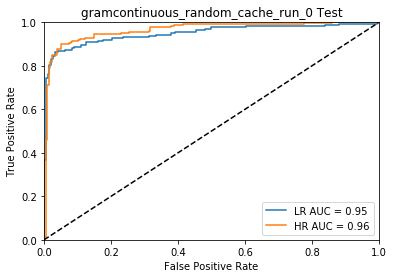

In [10]:
plot_test_roc_gram('gramcontinuous_random_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

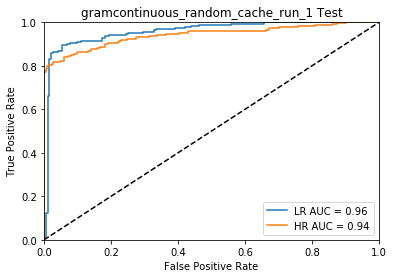

In [9]:
plot_test_roc_gram('gramcontinuous_random_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

# continous without cache

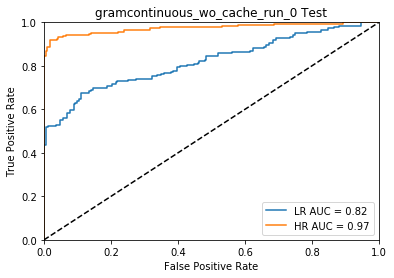

In [5]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

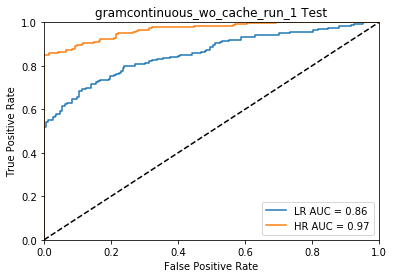

In [6]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

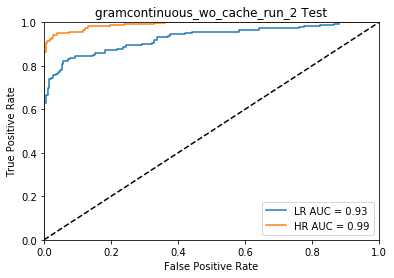

In [7]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_2', {'LR': test_lr, 'HR': test_hr}, device)

# Result Figures

In [12]:
df_wo_cache = None
for i in range(3):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_wo_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_wo_cache is None:
        df_wo_cache = df_temp
    else:
        df_wo_cache = df_wo_cache.append(df_temp)
        
        
df_randomcache = None

for i in range(4, 9):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_random_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_randomcache is None:
        df_randomcache = df_temp
    else:
        df_randomcache = df_randomcache.append(df_temp)


In [13]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = streamedDS.df.res == 'lr'

In [14]:
newcmp = ListedColormap([sns.color_palette()[1], sns.color_palette()[0]], name='OrangeBlue')

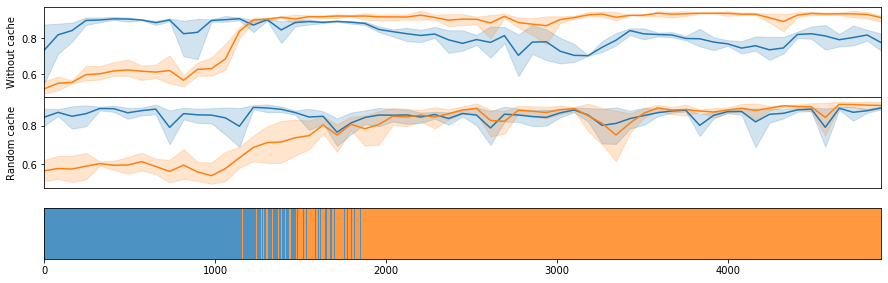

In [15]:
fig, ax = plt.subplots(3,1, figsize=(15, 5))

plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0])
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0])
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 60)
ax[0].set_ylabel('Without cache')

sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 60)
ax[1].set_ylabel('Random cache')

ax[2].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=0.8)
ax[2].get_yaxis().set_visible(False)
ax[2].get_yaxis()